## WS25: Seminar: Business Analytics (Master) - BWL 12
### Topic: Supply Chain Resilience under Disruptions — An Agent-Based Simulation with Mesa

In [ ]:
from model import MultiTierModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------
# Assumptions
# ---------------------------
assumptions = {
    "n_suppliers": 3,
    "n_plants": 3,
    "n_dcs": 2,
    "n_retailers": 5,
    "base_stock": {"supplier": 100, "plant": 80, "dc": 60, "retailer": 30},
    "capacity": {"supplier": 20, "plant": 15, "dc": 10, "retailer": 0},
    "lead_time": {"supplier": 1, "plant": 5, "dc": 5, "retailer": 2},
    "capacity_loss_frac": 0.5,
    "recovery_duration": 5,
    "holding_cost": 1,
    "backlog_cost": 5,
    "retailer_demand_mean": 5
}

n_steps = 50
scenarios = ["capacity_only", "lead_time_surge", "demand_spike"]

results_all = {}
# ---------------------------
# 2. Run simulation for each scenario
# ---------------------------
for scenario in scenarios:
    print(f"\n--- Running scenario: {scenario} ---")
    model = MultiTierModel(
        assumptions=assumptions,
        seed=42,
        dual_sourcing=True,
        disruption_at_step=10,
        scenario=scenario
    )
    
    fill_rates = []
    total_costs = []

    for step in range(n_steps):
        model.step()
        fill_rates.append(model.compute_fill_rate())
        total_costs.append(model.compute_total_cost())

    # Store results in DataFrame
    df = pd.DataFrame({
        "step": range(1, n_steps + 1),
        "fill_rate": fill_rates,
        "total_cost": total_costs
    })

    # Compute bullwhip once at the end
    bullwhip = model.compute_bullwhip()

    # Store all KPIs
    results_all[scenario] = {
        "df": df,
        "bullwhip": bullwhip,
        "time_to_recover": model.compute_time_to_recover()
    }


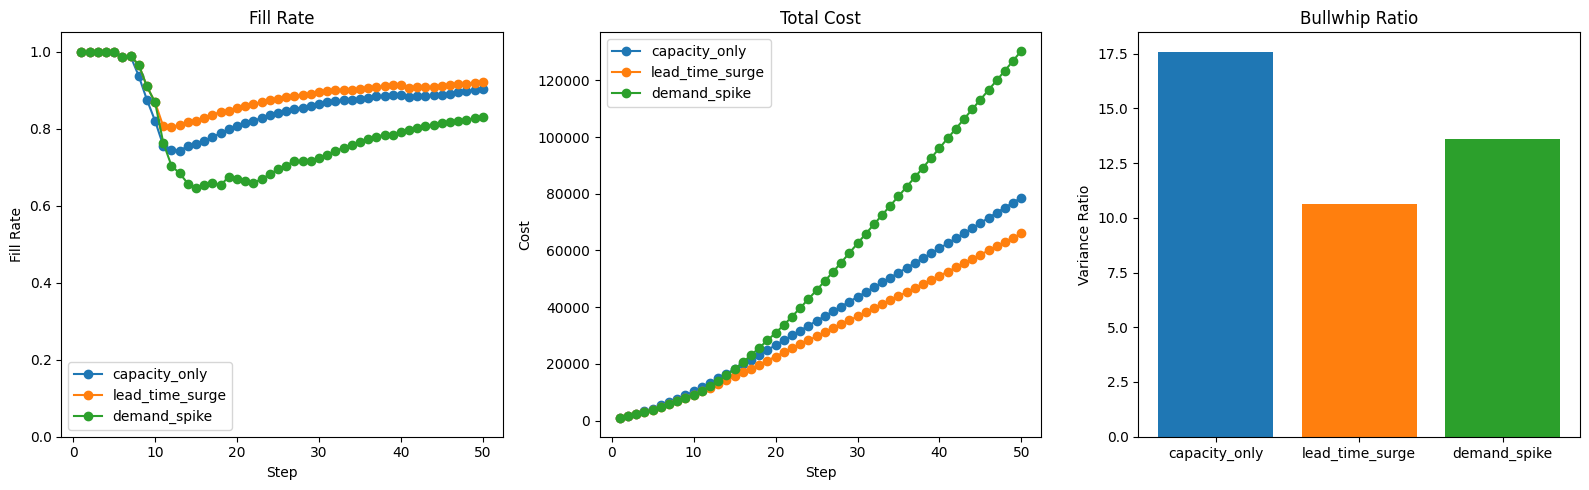


Scenario: capacity_only
Final Fill Rate: 0.902
Final Total Cost: 78682.00
Bullwhip Ratio: 17.591
Time to recover: 12.0 steps

Scenario: lead_time_surge
Final Fill Rate: 0.921
Final Total Cost: 65995.00
Bullwhip Ratio: 10.650
Time to recover: 13.0 steps

Scenario: demand_spike
Final Fill Rate: 0.831
Final Total Cost: 130483.00
Bullwhip Ratio: 13.594
Time to recover: nan steps


In [4]:
# ---------------------------
# 3. Plot KPI comparison
# ---------------------------
plt.figure(figsize=(16, 5))

# Fill Rate
plt.subplot(1, 3, 1)
for scenario in scenarios:
    plt.plot(results_all[scenario]["df"]["step"],
             results_all[scenario]["df"]["fill_rate"],
             marker='o', label=scenario)
plt.title("Fill Rate")
plt.xlabel("Step")
plt.ylabel("Fill Rate")
plt.ylim(0, 1.05)
plt.legend()

# Total Cost
plt.subplot(1, 3, 2)
for scenario in scenarios:
    plt.plot(results_all[scenario]["df"]["step"],
             results_all[scenario]["df"]["total_cost"],
             marker='o', label=scenario)
plt.title("Total Cost")
plt.xlabel("Step")
plt.ylabel("Cost")
plt.legend()

# Bullwhip
plt.subplot(1, 3, 3)
bullwhips = [results_all[s]["bullwhip"] for s in scenarios]
plt.bar(scenarios, bullwhips, color=['tab:blue', 'tab:orange', 'tab:green'])
plt.title("Bullwhip Ratio")
plt.ylabel("Variance Ratio")

plt.tight_layout()
plt.show()

# ---------------------------
# 4. Summary statistics
# ---------------------------
for scenario in scenarios:
    print(f"\nScenario: {scenario}")
    df = results_all[scenario]["df"]
    print(f"Final Fill Rate: {df['fill_rate'].iloc[-1]:.3f}")
    print(f"Final Total Cost: {df['total_cost'].iloc[-1]:.2f}")
    print(f"Bullwhip Ratio: {results_all[scenario]['bullwhip']:.3f}")
    print(f"Time to recover: {results_all[scenario]['time_to_recover']:.1f} steps")